# Wasserstein GAN with Gradient Penalty
## For generation of features based on LHCO2020 datasets

In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Using TensorFlow backend.


In [2]:
filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]
 # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    output_frame["mj1-mj2"] = output_frame["mj1"] -output_frame["mj2"]

    return output_frame

In [4]:
# Network hyperparameters

BATCH_SIZE = 2048# Uses about 3 GB of VRAM for batch size of 512
EPOCHS = 1000
LEARNING_RATE = 0.00001
N_CRITIC = 5
C_LAMBDA = 0.5

In [5]:
df = load_data("herwig")
df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
min(df["tau2j2"])

D:\Users\Azure\anaconda3\envs\GPU\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


1e-06

In [6]:
df = load_data("herwig")
df.dropna(inplace = True)
#df["tau2j2"]=np.where(df["tau2j2"]==0, 0.000001, df["tau2j2"]) 
# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)

df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,...,ej1,ej2,ejj,pjj,mjj,tau21j1,tau32j1,tau21j2,tau32j2,mj1-mj2
0,-606.640015,136.223999,-2463.290039,115.829002,41.708900,19.615000,16.282600,1410.239990,-311.454010,516.468018,...,2543.183594,1537.945679,4081.129395,840.942322,3993.548828,0.470283,0.830110,0.614313,0.647716,2.881004
1,1075.790039,560.247986,-473.667999,253.820999,98.636002,46.423801,37.188900,-785.905029,-476.933990,-1670.449951,...,1326.645630,1906.993530,3233.639160,312.914948,3218.463379,0.470658,0.801074,0.345675,0.681456,220.523193
2,-963.197998,-802.231995,-255.048004,369.252991,203.923996,32.369499,22.955299,1066.229980,662.479980,-1211.520020,...,1331.436768,1748.691895,3080.128662,222.883026,3072.053955,0.158733,0.709165,0.349252,0.687567,249.183990
3,-914.739014,-1285.349976,-390.425995,420.726013,183.169006,29.843300,24.244101,910.085022,1286.180054,228.893997,...,1678.783691,1593.454956,3272.238770,4.799760,3272.235107,0.162928,0.812380,0.515532,0.832525,355.978119
4,1178.770020,-442.437988,-816.497009,429.519989,272.453003,162.826004,113.084999,-945.479004,402.459015,-412.460999,...,1560.898804,1110.571655,2671.470459,240.044449,2660.664062,0.597630,0.694514,0.720654,0.639655,343.837708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999419,-710.262024,-1026.920044,-1307.729980,796.106995,744.283020,368.661987,210.828003,692.814026,976.697998,-41.325802,...,1975.596313,1198.612427,3174.208740,73.136452,3173.365967,0.495325,0.571873,0.770408,0.594857,763.957764
999420,-268.907990,1307.540039,1420.180054,333.614014,240.792007,171.697006,130.660995,155.938995,-1274.060059,-1473.140015,...,1977.418091,1957.884277,3935.302490,122.490051,3933.395508,0.713051,0.760998,0.298112,0.729554,208.620010
999421,314.462006,1388.619995,-158.914001,420.259003,295.635986,57.412300,44.277100,65.702904,-1444.400024,-1056.260010,...,1492.991333,1792.290039,3285.281494,388.263031,3262.257812,0.194199,0.771213,0.600804,0.573244,342.734100
999422,-133.639999,1522.699951,-229.511993,632.781006,504.207001,105.698997,48.149700,29.203501,-1470.739990,-839.638977,...,1670.198242,1704.347900,3374.546143,127.697525,3372.129150,0.209634,0.455536,0.705832,0.759785,443.363007


In [8]:
np.any(np.isnan(df))

False

In [9]:
df = df.drop(df.columns[[0,1,2,4,5,6,7,8,9,11,12,13,14,15,16,17,20,22]], axis=1)

In [10]:
df

,mj1,mj2,mjj,tau21j1,tau21j2,mj1-mj2
0,115.829002,112.947998,3993.548828,0.470283,0.614313,2.881004
1,253.820999,33.297798,3218.463379,0.470658,0.345675,220.523193
2,369.252991,120.069000,3072.053955,0.158733,0.349252,249.183990
3,420.726013,64.747902,3272.235107,0.162928,0.515532,355.978119
4,429.519989,85.682297,2660.664062,0.597630,0.720654,343.837708
...,...,...,...,...,...,...
999419,796.106995,32.149200,3173.365967,0.495325,0.770408,763.957764
999420,333.614014,124.994003,3933.395508,0.713051,0.298112,208.620010
999421,420.259003,77.524902,3262.257812,0.194199,0.600804,342.734100
999422,632.781006,189.417999,3372.129150,0.209634,0.705832,443.363007


In [11]:
# Normalize all inputs between -1 and 1

train_features = ["mj2"]
scaler = MinMaxScaler((-1,1)).fit(df[train_features])
feature_df = scaler.transform(df[train_features])

X_train, X_test = train_test_split(feature_df, test_size = 0.25)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))
gc.collect()

Dataset consists of 366 batches of 2048 samples each, total 749568 samples
Testset consists of 122 batches of 2048 samples each, total 249856 samples


20

In [12]:
X_train

array([[-0.856763  ],
       [-0.5991595 ],
       [-0.86924374],
       ...,
       [-0.8327837 ],
       [-0.91726404],
       [-0.6584562 ]], dtype=float32)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [14]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features), activation='tanh'))
    assert model.output_shape == (None, len(train_features))

    return model

In [15]:
generator = make_generator_model()

In [16]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [17]:
discriminator = make_discriminator_model()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [20]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [21]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [22]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [23]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=LEARNING_RATE)

In [24]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [25]:
@tf.function
def train_step_generator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [26]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [27]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [28]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, len(train_features)])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.uniform([BATCH_SIZE,len(train_features)],minval=0,maxval=1)

    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [29]:
def graph_gan(generator):
    fakedata = scaler.inverse_transform(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.ylabel("Normalized to Unity")
    
    plt.hist(df['mj2'], bins = 50, range = (0, 500), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 50, range = (0, 500), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()
    

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    
    print_losses = ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 100 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0


    # Training

    for image_batch in dataset:
      train_gen_loss += K_eval(train_step_generator(image_batch))
      for n in range(n_critic):
        train_disc_loss += K_eval(train_step_discriminator(image_batch))
    
    train_gen_losses.append(train_gen_loss / len_dataset)
    train_disc_losses.append(train_disc_loss / len_dataset / n_critic)

            
    # Evaluation

    for test_batch in testset:
      test_gen_loss += K_eval(evaluate_generator())
      test_disc_loss += K_eval(evaluate_discriminator(test_batch))

    test_gen_losses.append(test_gen_loss / len_testset)
    test_disc_losses.append(test_disc_loss / len_testset)

    # Logging

    if print_losses:
      print()

      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)

      graph_genloss()
      graph_discloss()


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

  1%|▊                                                                             | 10/1000 [02:22<3:53:38, 14.16s/it]


Epoch 10:

Generator training loss: -0.5864329800579717
Discriminator training loss: 0.013821683328999034

Generator validation loss: -0.5503347579573021
Discriminator validation loss: 0.029377981165393453


  2%|█▌                                                                            | 20/1000 [04:40<3:44:37, 13.75s/it]


Epoch 20:

Generator training loss: -2.07048238366028
Discriminator training loss: 0.13523114281681065

Generator validation loss: -2.150262746654573
Discriminator validation loss: 0.14280630232857877


  3%|██▎                                                                           | 30/1000 [06:59<3:42:36, 13.77s/it]


Epoch 30:

Generator training loss: -2.1393809996016038
Discriminator training loss: 0.13357616722013782

Generator validation loss: -2.3283097020915298
Discriminator validation loss: 0.15840994432324268


  4%|███                                                                           | 40/1000 [09:21<3:51:10, 14.45s/it]


Epoch 40:

Generator training loss: -2.012246808067697
Discriminator training loss: 0.10444709953796016

Generator validation loss: -2.433966535036681
Discriminator validation loss: 0.16257212433170098


  5%|███▉                                                                          | 50/1000 [11:41<3:42:48, 14.07s/it]


Epoch 50:

Generator training loss: -1.81725299130372
Discriminator training loss: 0.05438841374112609

Generator validation loss: -2.5185419067007597
Discriminator validation loss: 0.16061288081720226


  6%|████▋                                                                         | 60/1000 [13:59<3:35:54, 13.78s/it]


Epoch 60:

Generator training loss: -1.6136407138871365
Discriminator training loss: -0.002168730929474183

Generator validation loss: -2.6101043302504743
Discriminator validation loss: 0.019677509041312227


  7%|█████▍                                                                        | 70/1000 [16:18<3:34:00, 13.81s/it]


Epoch 70:

Generator training loss: -2.153355604963876
Discriminator training loss: -0.0014332964842914968

Generator validation loss: -2.8757230707856474
Discriminator validation loss: 0.0009469319161847826


  8%|██████▏                                                                       | 80/1000 [18:41<3:41:06, 14.42s/it]


Epoch 80:

Generator training loss: -2.607635214029114
Discriminator training loss: -0.0028343109255441106

Generator validation loss: -3.2213076724380745
Discriminator validation loss: 0.005686878306345325


  9%|███████                                                                       | 90/1000 [21:02<3:33:13, 14.06s/it]


Epoch 90:

Generator training loss: -2.8826241506253436
Discriminator training loss: 0.0009866591909281812

Generator validation loss: -3.4938389238764027
Discriminator validation loss: 0.002248455103549755


 10%|███████▋                                                                      | 99/1000 [23:09<3:32:07, 14.13s/it]


Epoch 100:

Generator training loss: -3.0264016656927724
Discriminator training loss: 0.0023796284622830534

Generator validation loss: -3.6829973908721425
Discriminator validation loss: -0.0004453060273441284

Epoch 100:


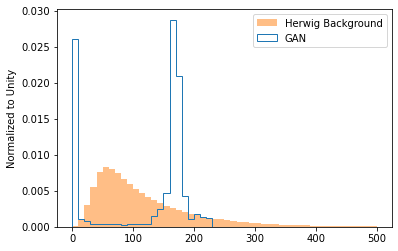

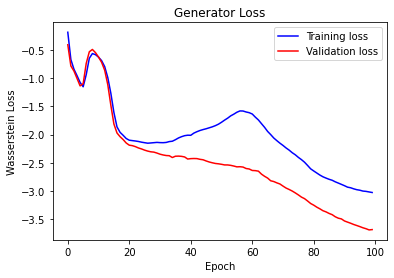

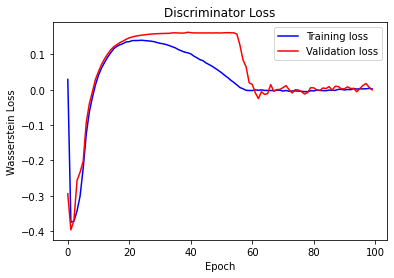

 11%|████████▍                                                                    | 110/1000 [25:43<3:26:08, 13.90s/it]


Epoch 110:

Generator training loss: -3.0661980995063574
Discriminator training loss: 0.008546850177341095

Generator validation loss: -3.791129313531469
Discriminator validation loss: 0.011473413766743462


 12%|█████████▏                                                                   | 120/1000 [28:04<3:23:52, 13.90s/it]


Epoch 120:

Generator training loss: -2.900633252383581
Discriminator training loss: 0.0056644507354646064

Generator validation loss: -3.6926349518729036
Discriminator validation loss: 0.021002455080141785


 13%|██████████                                                                   | 130/1000 [30:24<3:23:56, 14.07s/it]


Epoch 130:

Generator training loss: -2.775810351137255
Discriminator training loss: 0.005558849043548241

Generator validation loss: -3.6233851733754894
Discriminator validation loss: 0.034289475118161224


 14%|██████████▊                                                                  | 140/1000 [32:44<3:20:45, 14.01s/it]


Epoch 140:

Generator training loss: -2.7616938880232516
Discriminator training loss: 0.0009345597113057866

Generator validation loss: -3.643667649050228
Discriminator validation loss: 0.01872080033568696


 15%|███████████▌                                                                 | 150/1000 [35:05<3:19:54, 14.11s/it]


Epoch 150:

Generator training loss: -2.741931127720192
Discriminator training loss: 0.0010779997602796475

Generator validation loss: -3.615872832595325
Discriminator validation loss: -0.008357080447747082


 16%|████████████▎                                                                | 160/1000 [37:25<3:13:37, 13.83s/it]


Epoch 160:

Generator training loss: -2.758488977541689
Discriminator training loss: 0.0008832093579317711

Generator validation loss: -3.6375749638823214
Discriminator validation loss: 0.003624465438257235


 17%|█████████████                                                                | 170/1000 [39:43<3:12:26, 13.91s/it]


Epoch 170:

Generator training loss: -2.8317145285059193
Discriminator training loss: -0.002694030438646511

Generator validation loss: -3.704366283338578
Discriminator validation loss: -0.003494051333753484


 18%|█████████████▊                                                               | 180/1000 [42:03<3:12:52, 14.11s/it]


Epoch 180:

Generator training loss: -2.8892221046927196
Discriminator training loss: -0.004621102584148945

Generator validation loss: -3.774862740860611
Discriminator validation loss: -0.006397632117665633


 19%|██████████████▋                                                              | 190/1000 [44:23<3:12:11, 14.24s/it]


Epoch 190:

Generator training loss: -2.9729085359417025
Discriminator training loss: -0.00561814440317575

Generator validation loss: -3.7831981318895935
Discriminator validation loss: -0.04598445704848063


 20%|███████████████▎                                                             | 199/1000 [46:28<3:02:44, 13.69s/it]


Epoch 200:

Generator training loss: -3.0776478586301126
Discriminator training loss: -0.0027500369225791207

Generator validation loss: -3.9253305743952267
Discriminator validation loss: 0.008286497342642626

Epoch 200:


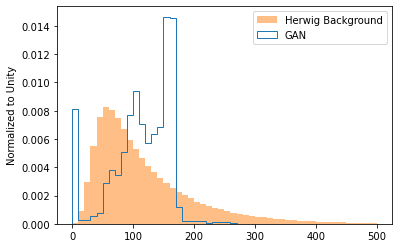

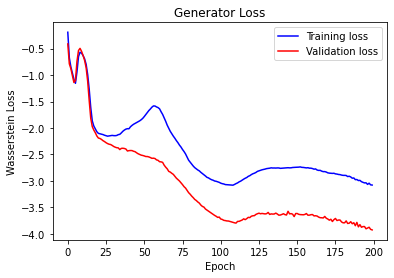

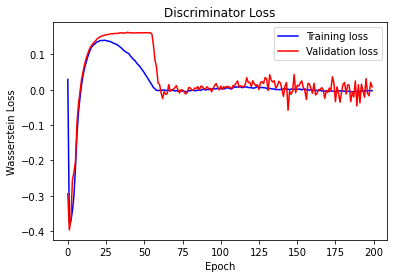

 21%|████████████████▏                                                            | 210/1000 [48:59<3:01:54, 13.82s/it]


Epoch 210:

Generator training loss: -3.1459572152361845
Discriminator training loss: -0.0025015262854279174

Generator validation loss: -3.954900632139112
Discriminator validation loss: -0.026588748575600445


 22%|████████████████▉                                                            | 220/1000 [51:17<2:59:44, 13.83s/it]


Epoch 220:

Generator training loss: -3.191762581549056
Discriminator training loss: 0.0009365066764075892

Generator validation loss: -4.0532757376061115
Discriminator validation loss: 0.006233474563427468


 23%|█████████████████▋                                                           | 230/1000 [53:35<2:58:36, 13.92s/it]


Epoch 230:

Generator training loss: -3.2541861924968782
Discriminator training loss: 0.000777451927542096

Generator validation loss: -4.0890048996346895
Discriminator validation loss: -0.011685200100459281


 24%|██████████████████▍                                                          | 240/1000 [55:55<2:56:44, 13.95s/it]


Epoch 240:

Generator training loss: -3.316122356008311
Discriminator training loss: 0.00034511446502306844

Generator validation loss: -4.17363223873201
Discriminator validation loss: 0.00533779286214682


 25%|███████████████████▎                                                         | 250/1000 [58:13<2:54:22, 13.95s/it]


Epoch 250:

Generator training loss: -3.3571568753549963
Discriminator training loss: 0.0006753884574219164

Generator validation loss: -4.190299495321805
Discriminator validation loss: -0.010087377160833385


 26%|███████████████████▌                                                       | 260/1000 [1:00:35<2:55:16, 14.21s/it]


Epoch 260:

Generator training loss: -3.3681261500374218
Discriminator training loss: 0.00021805085592452008

Generator validation loss: -4.153992344121464
Discriminator validation loss: -0.060134401514393386


 27%|████████████████████▎                                                      | 270/1000 [1:02:54<2:49:29, 13.93s/it]


Epoch 270:

Generator training loss: -3.42821305175948
Discriminator training loss: 0.0005168841288625733

Generator validation loss: -4.2528477027767995
Discriminator validation loss: 0.00883893069440688


 28%|█████████████████████                                                      | 280/1000 [1:05:14<2:48:21, 14.03s/it]


Epoch 280:

Generator training loss: -3.480046389532871
Discriminator training loss: 0.0003916225712869238

Generator validation loss: -4.337576811430885
Discriminator validation loss: 0.034665702368880884


 29%|█████████████████████▊                                                     | 290/1000 [1:07:34<2:47:34, 14.16s/it]


Epoch 290:

Generator training loss: -3.48035253722811
Discriminator training loss: 0.0013691521855246128

Generator validation loss: -4.301635535036931
Discriminator validation loss: 0.01117951493733181


 30%|██████████████████████▍                                                    | 299/1000 [1:09:39<2:42:45, 13.93s/it]


Epoch 300:

Generator training loss: -3.5365965639958614
Discriminator training loss: 0.00019285658087435956

Generator validation loss: -4.346260125519799
Discriminator validation loss: 0.025233243798195828

Epoch 300:


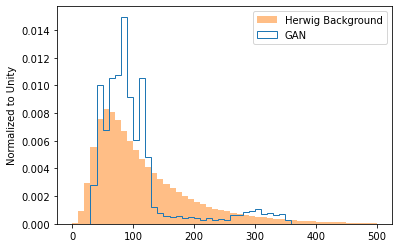

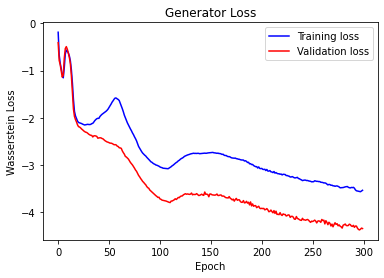

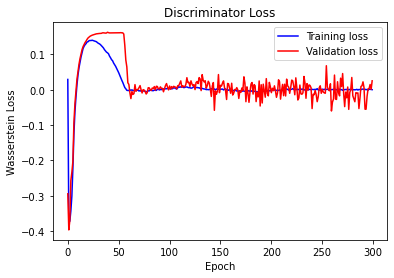

 31%|███████████████████████▎                                                   | 310/1000 [1:12:13<2:39:02, 13.83s/it]


Epoch 310:

Generator training loss: -3.6161290081472344
Discriminator training loss: 0.001117535255133455

Generator validation loss: -4.4145499018372085
Discriminator validation loss: 0.029452505261927355


 32%|████████████████████████                                                   | 320/1000 [1:14:31<2:37:24, 13.89s/it]


Epoch 320:

Generator training loss: -3.678784516339745
Discriminator training loss: 0.0016718517094613575

Generator validation loss: -4.454536410628772
Discriminator validation loss: -0.015988079449314564


 33%|████████████████████████▊                                                  | 330/1000 [1:16:51<2:35:45, 13.95s/it]


Epoch 330:

Generator training loss: -3.5982296297459
Discriminator training loss: 0.003998607786716938

Generator validation loss: -4.391106957294902
Discriminator validation loss: 0.00376066904910196


 34%|█████████████████████████▌                                                 | 340/1000 [1:19:11<2:32:51, 13.90s/it]


Epoch 340:

Generator training loss: -3.4542890103136905
Discriminator training loss: 0.0040499039878599576

Generator validation loss: -4.215264214844
Discriminator validation loss: -0.026434532107144106


 35%|██████████████████████████▎                                                | 350/1000 [1:21:31<2:31:15, 13.96s/it]


Epoch 350:

Generator training loss: -3.2927364834019395
Discriminator training loss: 0.00743446972016793

Generator validation loss: -4.089433978815547
Discriminator validation loss: 0.010557205093316983


 36%|███████████████████████████                                                | 360/1000 [1:23:51<2:29:12, 13.99s/it]


Epoch 360:

Generator training loss: -2.943423822929299
Discriminator training loss: 0.011130603441097512

Generator validation loss: -3.7586110009521736
Discriminator validation loss: 0.03911062252142879


 37%|███████████████████████████▊                                               | 370/1000 [1:26:11<2:28:11, 14.11s/it]


Epoch 370:

Generator training loss: -2.582818665791079
Discriminator training loss: 0.012463367112382424

Generator validation loss: -3.280654365899133
Discriminator validation loss: 0.024904693816559482


 38%|████████████████████████████▌                                              | 380/1000 [1:28:30<2:23:17, 13.87s/it]


Epoch 380:

Generator training loss: -2.303626866288524
Discriminator training loss: 0.007460249510601346

Generator validation loss: -3.0774525775284065
Discriminator validation loss: 0.005587406315841735


 39%|█████████████████████████████▎                                             | 390/1000 [1:30:50<2:22:58, 14.06s/it]


Epoch 390:

Generator training loss: -2.1895636040004876
Discriminator training loss: 0.0025214282395450154

Generator validation loss: -2.9143762334448393
Discriminator validation loss: 0.007307740463207277


 40%|█████████████████████████████▉                                             | 399/1000 [1:32:54<2:16:46, 13.65s/it]


Epoch 400:

Generator training loss: -2.0629740761277455
Discriminator training loss: 0.0017160487741709348

Generator validation loss: -2.8025360713239578
Discriminator validation loss: 0.019852989192929913

Epoch 400:


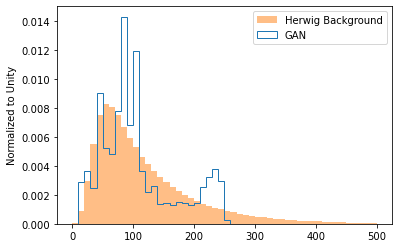

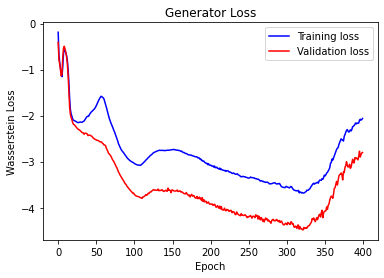

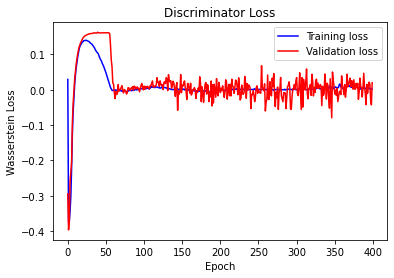

 41%|██████████████████████████████▋                                            | 410/1000 [1:35:28<2:15:12, 13.75s/it]


Epoch 410:

Generator training loss: -1.898733674177055
Discriminator training loss: 0.002345256868033712

Generator validation loss: -2.6419479182509127
Discriminator validation loss: 0.005696232186116996


 42%|███████████████████████████████▌                                           | 420/1000 [1:37:49<2:13:30, 13.81s/it]


Epoch 420:

Generator training loss: -1.7838955104676752
Discriminator training loss: 0.002575849810914331

Generator validation loss: -2.4859788066051047
Discriminator validation loss: -0.009165273668229213


 43%|████████████████████████████████▎                                          | 430/1000 [1:40:06<2:09:51, 13.67s/it]


Epoch 430:

Generator training loss: -1.588085226348189
Discriminator training loss: 0.006646737269301773

Generator validation loss: -2.285771448104108
Discriminator validation loss: -0.0032073582716278548


 44%|█████████████████████████████████                                          | 440/1000 [1:42:28<2:14:43, 14.44s/it]


Epoch 440:

Generator training loss: -1.4964670398847653
Discriminator training loss: 0.00029794611824012255

Generator validation loss: -2.2359710306417746
Discriminator validation loss: 0.02039990156553075


 45%|█████████████████████████████████▊                                         | 450/1000 [1:44:49<2:08:31, 14.02s/it]


Epoch 450:

Generator training loss: -1.4253962626222705
Discriminator training loss: 0.0012515179612918735

Generator validation loss: -2.0962191155699434
Discriminator validation loss: -0.004772384164351054


 46%|██████████████████████████████████▌                                        | 460/1000 [1:47:08<2:04:16, 13.81s/it]


Epoch 460:

Generator training loss: -1.474093549889945
Discriminator training loss: -9.324102123128633e-05

Generator validation loss: -2.1642734926255023
Discriminator validation loss: -0.006735743248890551


 47%|███████████████████████████████████▎                                       | 470/1000 [1:49:26<2:02:51, 13.91s/it]


Epoch 470:

Generator training loss: -1.5355877329091556
Discriminator training loss: 0.0014128009880754729

Generator validation loss: -2.2787277014529117
Discriminator validation loss: 0.004631755611745709


 48%|████████████████████████████████████                                       | 480/1000 [1:51:47<2:00:38, 13.92s/it]


Epoch 480:

Generator training loss: -1.663781522401695
Discriminator training loss: 0.0015990967751220453

Generator validation loss: -2.412965174581184
Discriminator validation loss: 0.010771637947296677


 49%|████████████████████████████████████▊                                      | 490/1000 [1:54:04<1:57:05, 13.78s/it]


Epoch 490:

Generator training loss: -1.6949129221869297
Discriminator training loss: 0.002070939132721574

Generator validation loss: -2.4724858237094565
Discriminator validation loss: 0.009748111368532934


 50%|█████████████████████████████████████▍                                     | 499/1000 [1:56:08<1:54:41, 13.74s/it]


Epoch 500:

Generator training loss: -1.7519408516545114
Discriminator training loss: 0.0007339771668714709

Generator validation loss: -2.5726515816860513
Discriminator validation loss: 0.0386454526518212

Epoch 500:


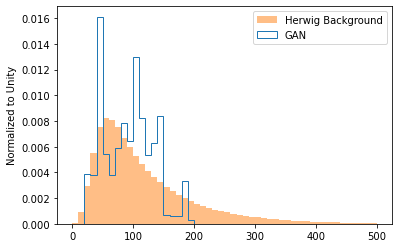

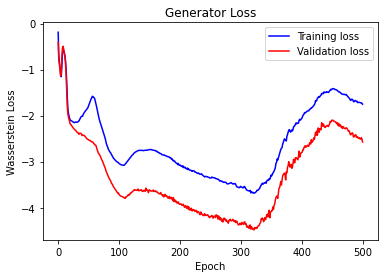

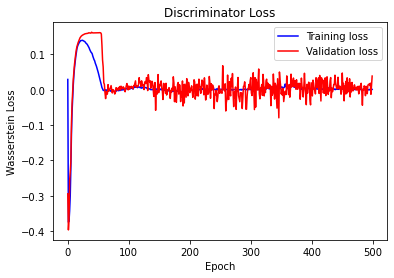

 51%|██████████████████████████████████████▎                                    | 510/1000 [1:58:41<1:52:53, 13.82s/it]


Epoch 510:

Generator training loss: -1.7674686944549853
Discriminator training loss: 0.0017572864144571351

Generator validation loss: -2.549338825413438
Discriminator validation loss: 0.013747064228795592


 52%|███████████████████████████████████████                                    | 520/1000 [2:01:00<1:52:30, 14.06s/it]


Epoch 520:

Generator training loss: -1.793409372939438
Discriminator training loss: 0.0020026114077706146

Generator validation loss: -2.570008184089035
Discriminator validation loss: 0.004965257175843094


 53%|███████████████████████████████████████▊                                   | 530/1000 [2:03:24<1:51:00, 14.17s/it]


Epoch 530:

Generator training loss: -1.7406713627075237
Discriminator training loss: 0.0011637501905383918

Generator validation loss: -2.5088348447299396
Discriminator validation loss: -0.02572170662556271


 54%|████████████████████████████████████████▌                                  | 540/1000 [2:05:45<1:47:12, 13.98s/it]


Epoch 540:

Generator training loss: -1.774704706799137
Discriminator training loss: -0.00016568476744769066

Generator validation loss: -2.5716519844336587
Discriminator validation loss: -0.031355457151400264


 55%|█████████████████████████████████████████▎                                 | 550/1000 [2:08:06<1:45:33, 14.08s/it]


Epoch 550:

Generator training loss: -1.8660428826926185
Discriminator training loss: -0.0009281650450789702

Generator validation loss: -2.6694844785283824
Discriminator validation loss: -0.0076588810983087225


 56%|██████████████████████████████████████████                                 | 560/1000 [2:10:26<1:42:12, 13.94s/it]


Epoch 560:

Generator training loss: -1.934275538217826
Discriminator training loss: 0.0015369187711764768

Generator validation loss: -2.7284826724255673
Discriminator validation loss: -0.004629126658431635


 57%|██████████████████████████████████████████▋                                | 570/1000 [2:12:47<1:42:11, 14.26s/it]


Epoch 570:

Generator training loss: -1.966645074346678
Discriminator training loss: 0.00023164978271376983

Generator validation loss: -2.7984391685392036
Discriminator validation loss: 0.035903692810383976


 58%|███████████████████████████████████████████▌                               | 580/1000 [2:15:08<1:38:42, 14.10s/it]


Epoch 580:

Generator training loss: -1.996863138805973
Discriminator training loss: -6.513964304321349e-05

Generator validation loss: -2.809228482793589
Discriminator validation loss: -0.0028271604500272975


 59%|████████████████████████████████████████████▎                              | 590/1000 [2:17:26<1:33:37, 13.70s/it]


Epoch 590:

Generator training loss: -1.9713143191702378
Discriminator training loss: 0.0006953894136951602

Generator validation loss: -2.7773110847004125
Discriminator validation loss: 0.010178914179139938


 60%|████████████████████████████████████████████▉                              | 599/1000 [2:19:30<1:31:44, 13.73s/it]


Epoch 600:

Generator training loss: -1.9425752247617545
Discriminator training loss: -0.00037116497214959905

Generator validation loss: -2.756398214668524
Discriminator validation loss: -0.013263541021857594

Epoch 600:


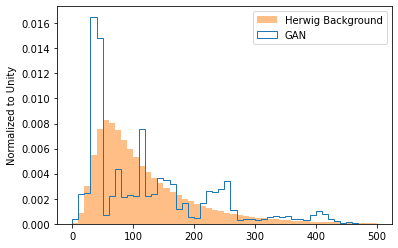

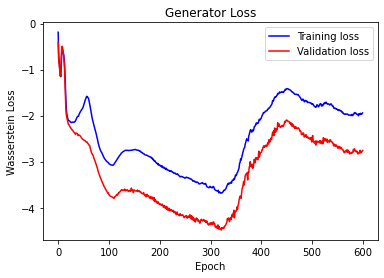

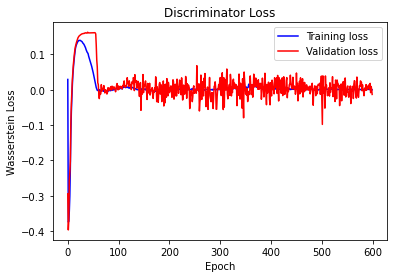

 61%|█████████████████████████████████████████████▊                             | 610/1000 [2:22:02<1:29:27, 13.76s/it]


Epoch 610:

Generator training loss: -1.9510006315069772
Discriminator training loss: -0.0005810927220255144

Generator validation loss: -2.7692100259124257
Discriminator validation loss: -0.017503528863374817


 62%|██████████████████████████████████████████████▌                            | 620/1000 [2:24:18<1:26:17, 13.63s/it]


Epoch 620:

Generator training loss: -1.9791631698608398
Discriminator training loss: -0.0006350176331912844

Generator validation loss: -2.806056089088565
Discriminator validation loss: 0.022827790393570406


 62%|██████████████████████████████████████████████▊                            | 624/1000 [2:25:13<1:25:34, 13.66s/it]

In [ ]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []
train(train_dataset, test_dataset, 1000, N_CRITIC)

## Results
Train for 4 features works pretty well and took 2:20 hrs for 1000 epos with a 1080

In [ ]:
z